In [1]:
using PyCall
@pyimport sys
@pyimport random
using PyPlot
plt = PyPlot

PyPlot

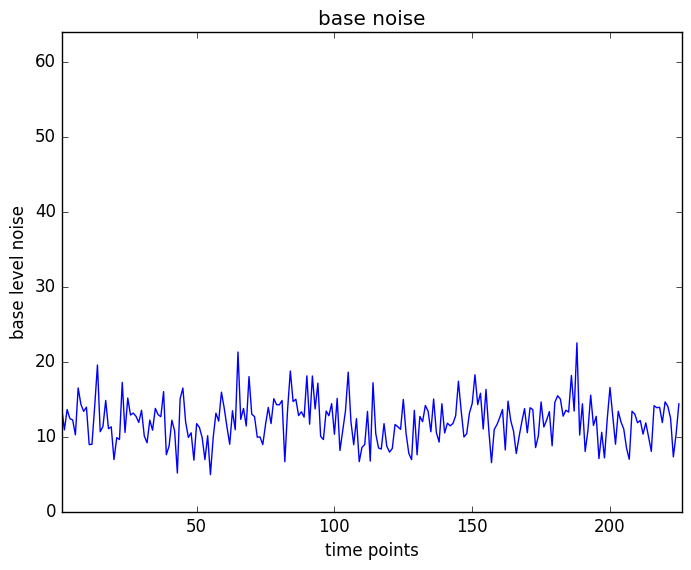

In [2]:
r = 12
base_level_noise = Float64[]
for i in 1:226
    push!(base_level_noise, r+3*randn())
end
plt.plot(base_level_noise)
plt.xlim(1,226)
plt.ylim(0,64)
xlabel("time points")
ylabel("base level noise")
title("base noise")
plt.savefig("base_noise.png")

In [3]:
#this type will  collect the data from a particular round of encrypter
type roundData
    inp::UInt64  #inp for that round
    key::UInt64  #key for that round
    outp::UInt64 #outp after addK-SLayer-PLayer
    trace::Array #the traces for that round
end
undef_round = roundData(0x0,0x0,0x0,zeros(226));

In [4]:
present_sbox = [0xC, 0x5, 0x6, 0xB, 0x9, 0x0, 0xA, 0xD, 0x3, 0xE, 0xF, 0x8, 0x4, 0x7, 0x1, 0x2];
present_pbox = [0, 16, 32, 48, 1, 17, 33, 49, 2, 18, 34, 50, 3, 19, 35, 51, 4, 20, 36, 52, 5, 21, 37, 53, 6, 22, 38, 54, 7, 23, 39, 55, 8, 24,
40, 56, 9, 25, 41, 57, 10, 26, 42, 58, 11, 27, 43, 59, 12, 28, 44, 60, 13, 29, 45, 61, 14, 30, 46, 62, 15, 31, 47, 63];

In [5]:
function HW(n)
    #n is a number of 64bits
    hw = 0
    s = bin(n,64)
    for i in 1:64
        if s[i] == '1'
            hw += 1
        end
    end
    hw
end

HW (generic function with 1 method)

In [6]:
#make sure arguement of HW is 0xform
HW(parse(UInt64,"1111111111111111111111111111111111111111111111111111111111111111",2))

64

In [7]:
#definition of the sboxLayer(state)
function sboxLayer(state)
    #state is UInt64
    new_state = ""
    bin_state = bin(state,64)
    for i in 4:4:64
        new_nibble = present_sbox[parse(Int,bin_state[i-3:i],2)+1] #is in UInt
        new_state = join([new_state,bin(new_nibble,4)]) #join appends the strings inside array
    end
    state = new_state
    parse(UInt64,state,2)
end

sboxLayer (generic function with 1 method)

In [8]:
sboxLayer(1)

0xccccccccccccccc5

In [9]:
#definition of the pLayer(state)
function pLayer(state)
    #state in UInt
    bin_state = bin(state,64)
    l = length(bin_state)
    newStateArray = fill('0',l)
    for i in 0:l-1
        newStateArray[present_pbox[l-i]+1] = bin_state[l-i]
    end
    state = join(newStateArray)
    parse(UInt64,state,2)
end

pLayer (generic function with 1 method)

In [10]:
pLayer(65)

0x0000000200000001

In [11]:
# K is 80bits long
function keyUpdate(K,i)
    #first rortate by 61 bits to the left
    K_new = rotate_str(K, 61)
    #update the 4 left more bits as given
    K_l4 = present_sbox[parse(Int8,K_new[1:4],2)+1]
    K_new = join([bin(K_l4,4),K_new[5:end]])
    #do xor of K_new[20:16] from right hand side and round counter
    K_in = bin((parse(Int8,K_new[61:65],2)$parse(Int8,bin(i,5),2)),5)
    K_new = join([K_new[1:60],K_in,K_new[66:end]])
end

#generic function to rotate the strings
function rotate_str(str,i)
    newstr = ""
    newstr = join([newstr,str[(i+1)%Int(length(str)):end]])
    newstr = join([newstr,str[1:(i%Int(length(str)))]])
end

function genKeys(K_initial)
    #K_initial is in UInt which can be accomodated in 80bits
    bin_K_initial = bin(K_initial,80)
    k_array = fill("",32)
    k_array[1] = bin_K_initial
    for i in 2:32
        k_array[i] = keyUpdate(k_array[i-1],i-1)
    end
    roundkeys = fill(UInt64(0),32)
    for i in 1:32
        roundkeys[i] = parse(UInt64,k_array[i][1:64],2)
    end
    roundkeys
end

genKeys (generic function with 1 method)

In [12]:
#testing genKeys
for k  in genKeys(0)
    println(k)
end

0
13835058055282163712
5764633911313301505
6917540022807691265
12682149744835821666
10376317730742599722
442003720503347
11529390968771969115
14988212656689645132
3459180129660437124
16147979721148203861
17296668118696855021
9227134571072480414
4618353464114686070
8183717834812044671
1198465691292819143
2366045755749583272
13941741584329639728
14494474964360714113
7646225019617799193
13645358504996018922
554074333738726254
4786096007684651070
4741631033305121237
17717416268623621775
3100551030501750445
9708113044954383277
10149619148849421687
2165863751534438555
15021127369453955789
10061738721142127305
7902464346767349504


In [13]:
#encryption with trace recording
function PRESENT_encrypter(K, inp)
    #K,inp both UInt, K can be accomodated in 80bits
    rounds = 31
    k_seed  = K
    keys = genKeys(k_seed)
    state = inp
    rounds_data = fill(undef_round,32)
    
    for i in 1:rounds
        round_inp = state
        round_key = keys[i]
        state = state$keys[i]
        state = sboxLayer(state)
        state = pLayer(state)
        round_outp = state
        
        round_trace = zeros(226)
        
        __ap = 2+randn()
        _ap = 2+2.25*randn()
        ap = HW(state) + 5*randn()
        ap_ = 2+2.25*randn()
        ap__ = 2+randn()
        
        round_trace[3+7*(i-1)] = __ap
        round_trace[4+7*(i-1)] = _ap
        round_trace[5+7*(i-1)] = ap
        round_trace[6+7*(i-1)] = ap_
        round_trace[7+7*(i-1)] = ap__        
        
        rounds_data[i] = roundData(round_inp,round_key,round_outp,round_trace)
    end
    i=32
    round_inp = state
    round_key = keys[32]
    state = state$keys[32]
    round_outp = state
    
    round_trace = zeros(226)
        
    __ap = randn()
    _ap = 1.25*randn()
    ap = HW(state) + 5*randn()
    ap_ = 1.25*randn()
    ap__ = randn()
        
    round_trace[3+7*(i-1)] = __ap
    round_trace[4+7*(i-1)] = _ap
    round_trace[5+7*(i-1)] = ap
    round_trace[6+7*(i-1)] = ap_
    round_trace[7+7*(i-1)] = ap__        
        
    rounds_data[i] = roundData(round_inp,round_key,round_outp,round_trace)
    
    rounds_data
end

PRESENT_encrypter (generic function with 1 method)

In [14]:
K = 0xab987654def32c01f456
inp = 0x987654321
r_data = PRESENT_encrypter(K,inp);

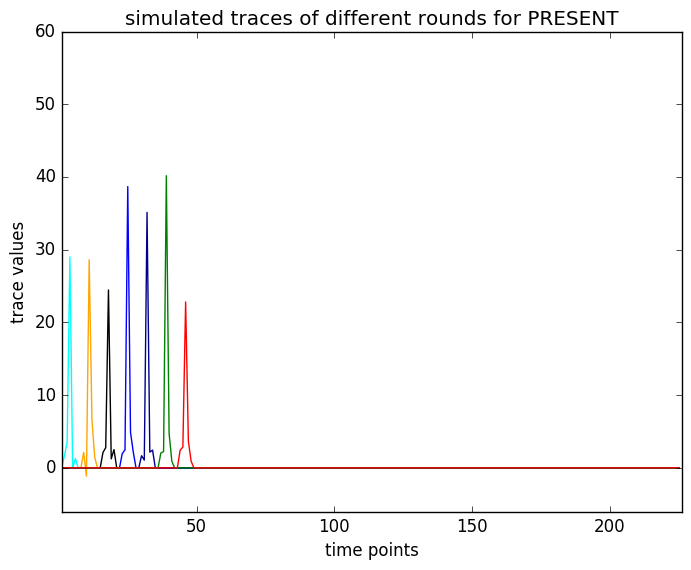

In [15]:
plt.plot(r_data[1].trace,color="cyan")
plt.plot(r_data[2].trace,color="orange")
plt.plot(r_data[3].trace,color="black")
plt.plot(r_data[4].trace,color="blue")
plt.plot(r_data[5].trace,color="darkblue")
plt.plot(r_data[6].trace,color="green")
plt.plot(r_data[7].trace,color="red")
plt.xlim(1,226)
plt.ylim(-6,60)
xlabel("time points")
ylabel("trace values")
title("simulated traces of different rounds for PRESENT")
plt.savefig("simulated_diff_round_individual.png")

In [16]:
trace_without_basenoise = zeros(226)
for i in 1:32
    trace_without_basenoise += r_data[i].trace
end

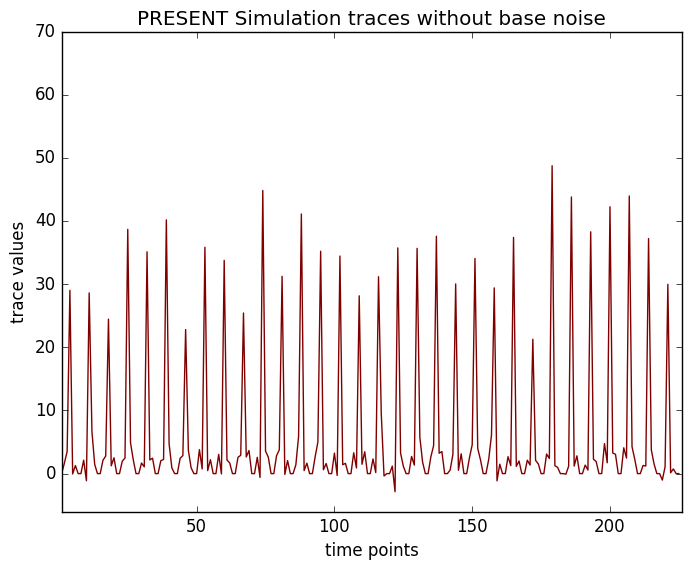

In [17]:
plt.plot(trace_without_basenoise,color="maroon")
plt.xlim(1,226)
plt.ylim(-6,70)
xlabel("time points")
ylabel("trace values")
title("PRESENT Simulation traces without base noise")
plt.savefig("net_without_base.png")

In [18]:
trace_simu = trace_without_basenoise+base_level_noise;

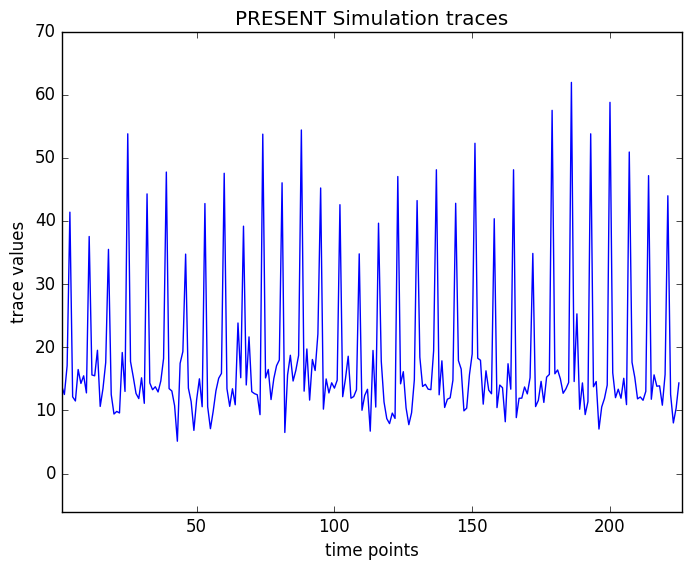

In [19]:
#plt.plot(base_level_noise,color="red")
#plt.plot(trace_without_basenoise,color="green")
plt.plot(trace_simu,color="blue")
plt.xlim(1,226)
plt.ylim(-6,70)
xlabel("time points")
ylabel("trace values")
title("PRESENT Simulation traces")
plt.savefig("overall simulated trace")

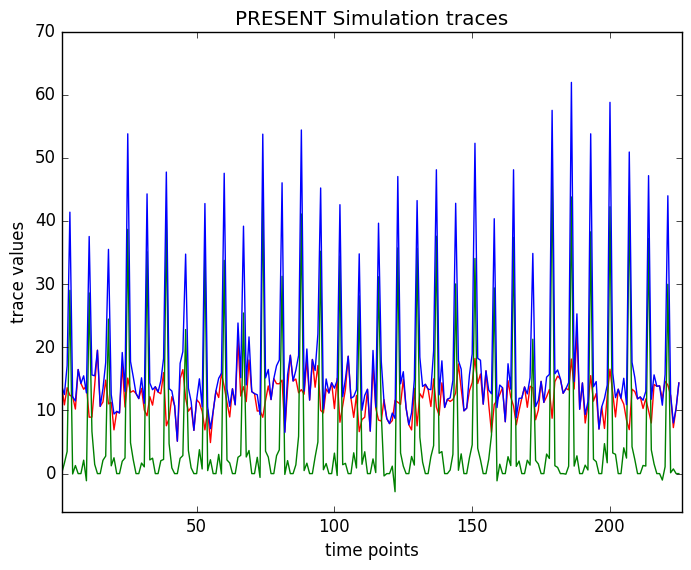

In [20]:
plt.plot(base_level_noise,color="red")
plt.plot(trace_without_basenoise,color="green")
plt.plot(trace_simu,color="blue")
plt.xlim(1,226)
plt.ylim(-6,70)
xlabel("time points")
ylabel("trace values")
title("PRESENT Simulation traces")
plt.savefig("all_together")

In [21]:
#function that gives the trace line corresponding to (PT,CT,traces)
function gentraces(K,PT)
    r_data = PRESENT_encrypter(K,PT)
    trace_without_basenoise = zeros(226)
    for i in 1:32
        trace_without_basenoise += r_data[i].trace
    end
    trace_simu = trace_without_basenoise+base_level_noise;
    CT = r_data[32].outp
    t_line = ""
    for t in trace_simu
        t_line = join([t_line, ",$(t)"])
    end
    return(join([hex(PT,16),',',hex(CT,16),t_line,"\n"]))
end

gentraces (generic function with 1 method)

In [22]:
#testing gentraces
gentraces(0xab987654def32c01f456,0)

"0000000000000000,8289a776ad7b95be,8.701104037774165,13.919467691552164,12.193795792918394,19.1232642555051,46.476025582216586,14.593465172294922,12.765931239296375,16.477846928941023,14.276932836199629,16.239854559908835,12.292313480966676,42.058556331555465,11.831021353061967,15.182898564410714,19.530934295632527,10.638130087801597,14.28796495018829,19.043451420437908,52.01128088153352,14.96518007901678,8.463137621951361,9.84539102172462,9.60119449835848,18.363521613007904,10.540012336802281,40.85845827186978,14.81483510409992,13.981891644623941,12.68451340642049,11.878905549667923,15.27424263045114,14.255593397081604,35.47704741340981,13.40851907852333,15.303843173975423,13.7507904448592,12.926989804358815,13.275069322562985,16.81744374332834,47.29132832437855,12.15547450685099,13.815316713232352,10.748504261537587,5.129482847754664,17.200357970003502,22.916825827816346,46.10600573825563,12.035683257726756,12.54098412483836,6.844926326141679,11.711150066857885,12.780543862990244,12.

In [54]:
#generating traces to try DPA
k_master = 0xab987654def32c01f456
n_files = 20
n_traces = 2500
for i in 1:n_files
    tr_lines = String[]
    for j in 1:n_traces
        sleep(0.02)
        PT = rand(0:0xffffffffffffffff)
        push!(tr_lines,gentraces(k_master,PT))
    end
    f = open("/home/ud/Documents/NTU_research/PRESENT_simulation_traces/$(k_master)_$(i).csv","w")
    for s in tr_lines
        write(f,s)
    end
    close(f)
end